# Diabetes Prediction with Logistic Regression

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [6]:
df = pd.read_csv("datasets/diabetes.csv")

### Data Preprocessing (Veri Ön İşleme)

In [7]:
cols = [col for col in df.columns if "Outcome" not in col]

for col in cols:
    print(col, check_outlier(df, col))

replace_with_thresholds(df, "Insulin")

for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

df.head()

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


### Model & Prediction

In [9]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

In [10]:
log_model.intercept_

array([-1.23439588])

In [11]:
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [12]:
y_pred = log_model.predict(X)

In [13]:
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [14]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

### Model Evaluation

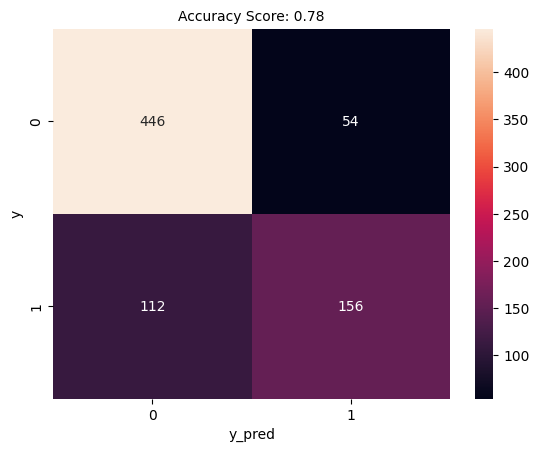

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [18]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

print(classification_report(y, y_pred))

In [19]:
# ROC AUC
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8393955223880598

### Model Validation: Holdout

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

log_model = LogisticRegression().fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


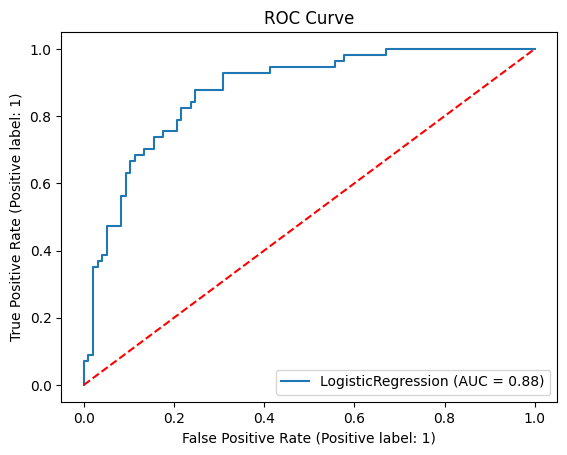

In [22]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [23]:
# AUC
roc_auc_score(y_test, y_prob)

0.8755652016639537

### Model Validation: 10-Fold Cross Validation

In [25]:
log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [26]:
cv_results['test_accuracy'].mean()

0.7721925133689839

In [27]:
cv_results['test_precision'].mean()

0.7192472060223519

In [28]:
cv_results['test_recall'].mean()

0.5747030048916841

In [29]:
cv_results['test_f1'].mean()

0.6371421090986309

In [30]:
cv_results['test_roc_auc'].mean()

0.8327295597484277

### Prediction for A New Observation

In [32]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [33]:
random_user = X.sample(1, random_state=45)
log_model.predict(random_user)

array([1])